In [65]:
import psycopg2
import pandas as pd
import json
from urllib.parse import urlparse

In [31]:


with open('database_config.json') as json_file:
    db_config = json.load(json_file)['gcp']
conn = psycopg2.connect(host=db_config['host'], user=db_config['user'], password=db_config['password'], database=db_config['database'], port=db_config['port'])
sql = 'SELECT * FROM "deepcite_call" ORDER by "created_at" DESC;'
mega_df = pd.read_sql_query(sql, conn)
mega_df = pd.concat([mega_df.drop(['response'], axis=1), mega_df['response'].apply(pd.Series)], axis=1).set_index('id')
mega_df.columns

Index(['user_id', 'stage', 'status_code', 'response_time_elapsed',
       'current_versions', 'created_at', 'error', 'results'],
      dtype='object')

In [6]:
# mega_df[['response_time_elapsed', 'current_versions']].groupby('current_versions').sum()
def items_func(x):
    return tuple(sorted(x.items()))
mega_df['list_versions'] = mega_df.current_versions.apply(items_func)

mega_df[['response_time_elapsed', 'list_versions']].groupby('list_versions').mean()

,response_time_elapsed
list_versions,
"((api, 0.3.0), (extension, 1.1.0), (lambda, 0.3.0), (model, 0.6.0))",26.000000
"((api, 0.4.0), (extension, 1.2.1), (lambda, 0.4.0), (model, 0.6.0))",43.277778
"((api, 0.4.0), (extension, 1.3.0), (lambda, 0.5.0), (model, 0.6.0))",80.166667
"((api, 0.4.0), (extension, 1.4.0), (lambda, 0.6.0), (model, 0.7.0))",36.661538
"((api, 0.4.0), (extension, 1.4.1), (lambda, 0.7.0), (model, 0.7.0))",33.272727
"((api, 0.4.0), (extension, 1.5.0), (lambda, 0.7.1), (model, 0.8.0))",68.923077


In [30]:
mega_df.response_time_elapsed.quantile(.9)

84.0

## Select Current versions and add metadata

In [98]:
cur_df = pd.concat([mega_df.drop(['current_versions'], axis=1), mega_df['current_versions'].apply(pd.Series)], axis=1)
cur_df = cur_df[(cur_df.api=='0.4.0')&(cur_df.extension=='1.5.0')&(cur_df['lambda']=='0.7.1')&(cur_df.model=='0.8.0')]

def get_host(url):
    try:
        return urlparse(url).hostname
    except ValueError:
        return 'Malfunction'

def returned_metadata(row):
    '''Summary of data returned from deepcite'''
    # ['link', 'score', 'citeID', 'source', 'parentCiteID']
    df = pd.json_normalize(row.results)
    df['host'] = df.link.apply(get_host)
    host_count = dict(df.host.value_counts())
    errored_hosts = dict(df[df.score < 0].host.value_counts())
    # max_height = 

    return pd.Series({'mean_score': df.score.mean(), 'root_host': get_host(df.iloc[0].link), 'host_count': host_count,
                      'errored_hosts': errored_hosts})

cur_df = pd.concat([cur_df, cur_df.apply(returned_metadata, axis=1)], axis=1)
cur_df.columns

Index(['user_id', 'stage', 'status_code', 'response_time_elapsed',
       'created_at', 'error', 'results', 'api', 'model', 'lambda', 'extension',
       'mean_score', 'root_host', 'host_count', 'errored_hosts'],
      dtype='object')

## Problem Links

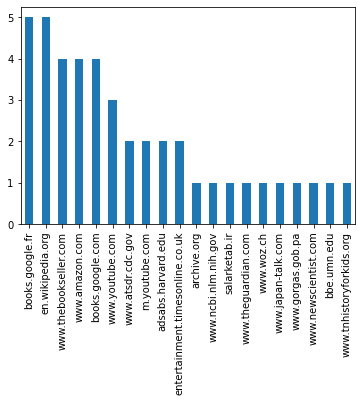

In [171]:
errored_hosts_totals = cur_df[(cur_df.error != 'none') | (cur_df.status_code != 200)].root_host.value_counts()

errored_hosts_totals = cur_df.errored_hosts.apply(pd.Series).append(errored_hosts_totals.to_frame().transpose()).sum()
errored_hosts_totals.sort_values(ascending=False)[:20].plot.bar()

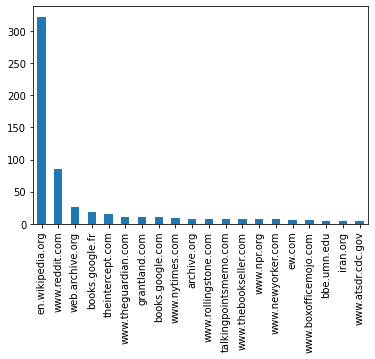

In [172]:
cur_df.host_count.apply(pd.Series).sum().sort_values(ascending=False)[:20].plot.bar()